# Algorithm Comparison Notebook (5 Minute Time Limit)

This notebook tests all optimization algorithms with a **5-minute time budget** per algorithm.

**Comparisons:**
1. **Algorithms**: Hill Climbing, Simulated Annealing, GA Greedy, GA Tournament
2. **Heuristic**: With/Without heuristic initialization (GA only)
3. **Fitness Metrics**: L1 (Manhattan) vs L2 (SSD)
4. **Shapes**: Rect, Circle, Ellipse, Triangle

All results tracked by **elapsed seconds** for fair comparison.

**Output:** All figures saved to `docs/<experiment>/` directories.

In [1]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from pathlib import Path

# Import from our modules
from genotype import Genotype, Rect, Circle, Ellipse, Triangle
from utils import (
    load_img, initialize_grid, generate_phenotype,
    compute_fitness, compute_fitness_l1, get_jittered_grid_individual
)
from algorithms import (
    hill_climbing, simulated_annealing,
    ga_greedy, ga_tournament
)

# Create docs directory structure
DOCS_DIR = Path("docs")
DOCS_DIR.mkdir(exist_ok=True)

Running each algorithm for 5 minutes (300 seconds)
Image loaded and resized to: 256x512
Image size: 256x512


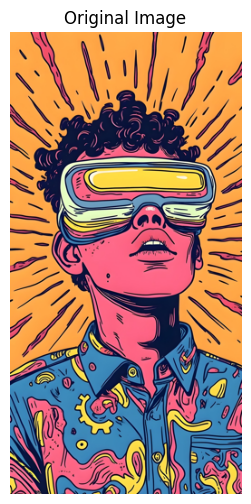

Saved: docs/original_image.png


In [2]:
# Configuration
IMAGE_PATH = "./popart.png" 
MAX_TIME_MINUTES = 5       # 5 minutes per algorithm
MAX_TIME_SEC = MAX_TIME_MINUTES * 60  # Convert to seconds
MAX_ITER = 1000000         # High enough to not limit before time
POP_SIZE = 20              # Population size for GAs
GRID_SIZE = 5              # Grid size for local search init

print(f"Running each algorithm for {MAX_TIME_MINUTES} minutes ({MAX_TIME_SEC} seconds)")

# Load image
original_img, w, h = load_img(IMAGE_PATH)
print(f"Image size: {w}x{h}")

# Display original image
plt.figure(figsize=(6, 6))
plt.imshow(original_img)
plt.title("Original Image")
plt.axis("off")
plt.savefig(DOCS_DIR / "original_image.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {DOCS_DIR / 'original_image.png'}")

## Helper Functions

In [3]:
def ensure_dir(path: Path):
    """Create directory if it doesn't exist."""
    path.mkdir(parents=True, exist_ok=True)
    return path

def run_experiment(name, algorithm_fn, **kwargs):
    """Run a single experiment and return results."""
    print(f"\n{'='*50}")
    print(f"Running: {name}")
    print(f"{'='*50}")
    
    start = time.time()
    best_geno, history = algorithm_fn(**kwargs)
    elapsed = time.time() - start
    
    final_fitness = history[-1][1] if history else float('inf')
    
    print(f"Final fitness: {final_fitness:,.0f}")
    print(f"Shapes: {len(best_geno.shapes)}")
    print(f"Time: {elapsed:.2f}s ({elapsed/60:.2f} min)")
    print(f"Iterations completed: {len(history)}")
    
    return {
        'name': name,
        'geno': best_geno,
        'history': history,
        'final_fitness': final_fitness,
        'time': elapsed,
        'shapes': len(best_geno.shapes),
        'iterations': len(history)
    }

def plot_fitness_by_time(results, title="Fitness by Time", save_dir=None):
    """Plot fitness evolution over elapsed time (seconds)."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Fitness over time
    ax1 = axes[0]
    for r in results:
        times = [h[0] for h in r['history']]
        fitness = [h[1] for h in r['history']]
        ax1.plot(times, fitness, label=r['name'], linewidth=1.5)
    ax1.set_xlabel('Time (seconds)')
    ax1.set_ylabel('Fitness (lower is better)')
    ax1.set_title(f'{title} - Fitness Evolution')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    # Final fitness bar chart
    ax2 = axes[1]
    names = [r['name'] for r in results]
    fitness_vals = [r['final_fitness'] for r in results]
    colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(names)))
    bars = ax2.bar(range(len(names)), fitness_vals, color=colors)
    ax2.set_xticks(range(len(names)))
    ax2.set_xticklabels(names, rotation=45, ha='right')
    ax2.set_ylabel('Final Fitness')
    ax2.set_title(f'{title} - Final Fitness After {MAX_TIME_MINUTES} min')
    
    for bar, val in zip(bars, fitness_vals):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                 f'{val:,.0f}', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    
    if save_dir:
        save_path = save_dir / "fitness_comparison.png"
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()

def plot_convergence_rate(results, title="Convergence Rate", save_dir=None):
    """Show how quickly each algorithm improves."""
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for r in results:
        if not r['history']:
            continue
        times = [h[0] for h in r['history']]
        fitness = [h[1] for h in r['history']]
        
        start_fitness = fitness[0]
        improvement_pct = [(start_fitness - f) / start_fitness * 100 for f in fitness]
        
        ax.plot(times, improvement_pct, label=r['name'], linewidth=1.5)
    
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Improvement %')
    ax.set_title(f'{title} - Improvement Over Time')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    
    if save_dir:
        save_path = save_dir / "convergence_rate.png"
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()

def show_phenotypes(results, cols=4, save_dir=None):
    """Display and save generated phenotypes."""
    n = len(results)
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
    axes = axes.flatten() if n > 1 else [axes]
    
    for i, r in enumerate(results):
        phenotype = generate_phenotype(r['geno'].w, r['geno'].h, r['geno'].shapes)
        axes[i].imshow(phenotype)
        axes[i].set_title(f"{r['name']}\nFitness: {r['final_fitness']:,.0f}\nShapes: {r['shapes']}")
        axes[i].axis('off')
        
        # Save individual phenotype
        if save_dir:
            safe_name = r['name'].replace(' ', '_').replace('(', '').replace(')', '').lower()
            img_path = save_dir / f"phenotype_{safe_name}.png"
            Image.fromarray(phenotype).save(img_path)
    
    for i in range(n, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    
    if save_dir:
        save_path = save_dir / "phenotypes_grid.png"
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()

---
## 1. All Algorithms Comparison (Rect, L2, No Heuristic)

In [4]:
EXP1_DIR = ensure_dir(DOCS_DIR / "01_all_algorithms")

shape_class = Rect
fitness_fn = compute_fitness

results_basic = []

# Hill Climbing
start_geno = initialize_grid(original_img, w, h, shape_class, grid_size=GRID_SIZE)
results_basic.append(run_experiment(
    "Hill Climbing",
    hill_climbing,
    geno=start_geno, original_img=original_img, shape_class=shape_class,
    max_it=MAX_ITER, max_time=MAX_TIME_SEC,
    track_by_time=True, fitness_fn=fitness_fn
))

# Simulated Annealing
start_geno = initialize_grid(original_img, w, h, shape_class, grid_size=GRID_SIZE)
results_basic.append(run_experiment(
    "Simulated Annealing",
    simulated_annealing,
    geno=start_geno, original_img=original_img, shape_class=shape_class,
    max_it=MAX_ITER, max_time=MAX_TIME_SEC,
    track_by_time=True, fitness_fn=fitness_fn
))

# GA Greedy
results_basic.append(run_experiment(
    "GA Greedy",
    ga_greedy,
    original_img=original_img, shape_class=shape_class,
    pop_size=POP_SIZE, max_it=MAX_ITER, max_time=MAX_TIME_SEC,
    track_by_time=True, fitness_fn=fitness_fn
))

# GA Tournament
results_basic.append(run_experiment(
    "GA Tournament",
    ga_tournament,
    original_img=original_img, shape_class=shape_class,
    pop_size=POP_SIZE, max_it=MAX_ITER, max_time=MAX_TIME_SEC,
    track_by_time=True, fitness_fn=fitness_fn
))


Running: Hill Climbing


Hill Climbing:   0%|          | 0/1000000 [00:00<?, ?it/s]

Hill Climbing:   3%|▎         | 28379/1000000 [05:00<2:51:11, 94.60it/s, Score=1,267,678,366, Stag=7]  


Stopping at iteration 28379 - time limit reached (300.0s)
Final fitness: 1,267,678,366
Shapes: 98
Time: 300.01s (5.00 min)
Iterations completed: 28379

Running: Simulated Annealing


Simulated Annealing:   3%|▎         | 31450/1000000 [05:00<2:33:59, 104.83it/s, Best=1,274,659,258, Temp=0.0] 


Stopping at iteration 31450 - time limit reached (300.0s)
Final fitness: 1,274,659,258
Shapes: 85
Time: 300.01s (5.00 min)
Iterations completed: 31450

Running: GA Greedy
Initializing Population...


GA (greedy):   0%|          | 1959/1000000 [05:00<42:28:17,  6.53it/s, Best=1,353,826,460, Shapes=58]


Stopping at generation 1959 - time limit reached (300.0s)
Final fitness: 1,353,826,460
Shapes: 58
Time: 300.12s (5.00 min)
Iterations completed: 1959

Running: GA Tournament
Initializing Population...


GA (tournament):   0%|          | 2641/1000000 [05:00<31:28:51,  8.80it/s, Best=1,375,076,614, Shapes=44]

Stopping at generation 2641 - time limit reached (300.0s)
Final fitness: 1,375,076,614
Shapes: 44
Time: 300.10s (5.00 min)
Iterations completed: 2641


Saved: docs/01_all_algorithms/fitness_comparison.png


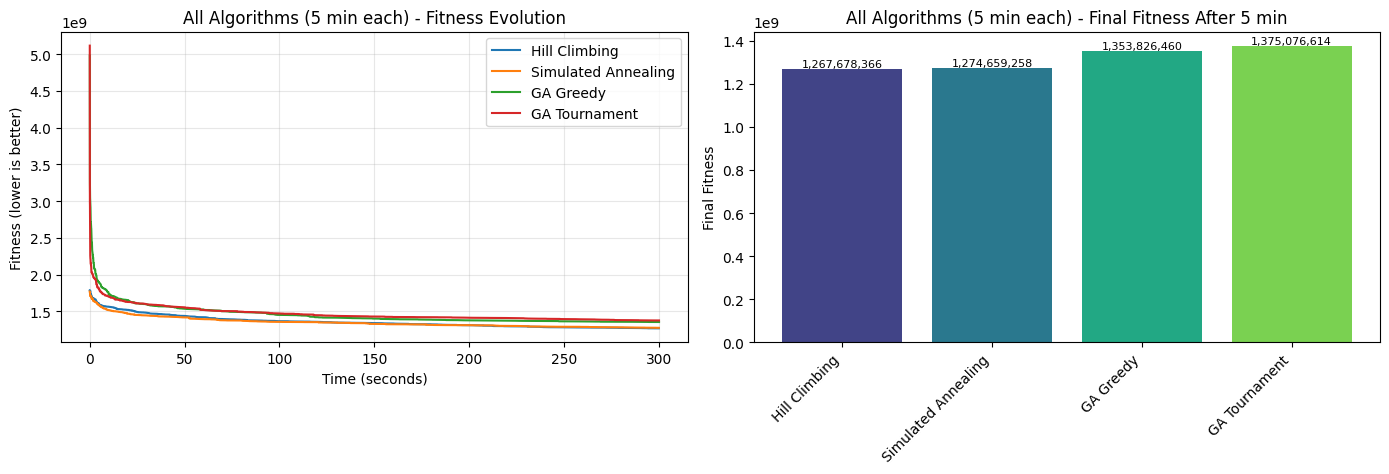

Saved: docs/01_all_algorithms/convergence_rate.png


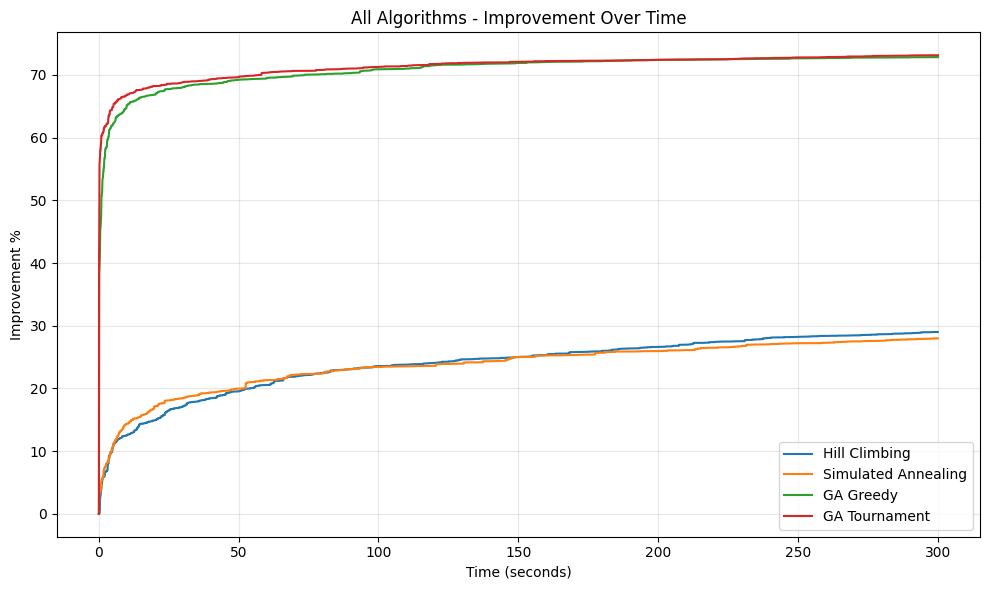

Saved: docs/01_all_algorithms/phenotypes_grid.png


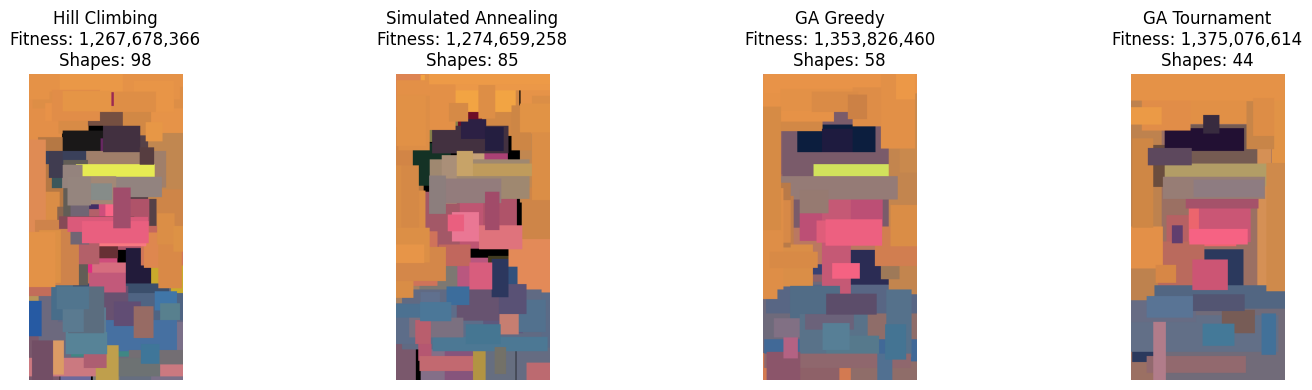

In [5]:
plot_fitness_by_time(results_basic, "All Algorithms (5 min each)", save_dir=EXP1_DIR)
plot_convergence_rate(results_basic, "All Algorithms", save_dir=EXP1_DIR)
show_phenotypes(results_basic, save_dir=EXP1_DIR)

---
## 2. Heuristic vs No Heuristic (GA only)

In [6]:
EXP2_DIR = ensure_dir(DOCS_DIR / "02_heuristic_comparison")

results_heuristic = []

# GA Tournament WITHOUT heuristic
results_heuristic.append(run_experiment(
    "GA Tournament (No Heuristic)",
    ga_tournament,
    original_img=original_img, shape_class=Rect,
    pop_size=POP_SIZE, max_it=MAX_ITER, max_time=MAX_TIME_SEC,
    fitness_fn=compute_fitness, use_heuristic=False, track_by_time=True
))

# GA Tournament WITH heuristic
results_heuristic.append(run_experiment(
    "GA Tournament (With Heuristic)",
    ga_tournament,
    original_img=original_img, shape_class=Rect,
    pop_size=POP_SIZE, max_it=MAX_ITER, max_time=MAX_TIME_SEC,
    fitness_fn=compute_fitness, use_heuristic=True, track_by_time=True
))

# GA Greedy WITHOUT heuristic
results_heuristic.append(run_experiment(
    "GA Greedy (No Heuristic)",
    ga_greedy,
    original_img=original_img, shape_class=Rect,
    pop_size=POP_SIZE, max_it=MAX_ITER, max_time=MAX_TIME_SEC,
    fitness_fn=compute_fitness, use_heuristic=False, track_by_time=True
))

# GA Greedy WITH heuristic
results_heuristic.append(run_experiment(
    "GA Greedy (With Heuristic)",
    ga_greedy,
    original_img=original_img, shape_class=Rect,
    pop_size=POP_SIZE, max_it=MAX_ITER, max_time=MAX_TIME_SEC,
    fitness_fn=compute_fitness, use_heuristic=True, track_by_time=True
))


Running: GA Tournament (No Heuristic)
Initializing Population...


GA (tournament):   0%|          | 2274/1000000 [05:00<36:34:01,  7.58it/s, Best=1,393,830,903, Shapes=43]


Stopping at generation 2274 - time limit reached (300.0s)
Final fitness: 1,393,830,903
Shapes: 43
Time: 300.04s (5.00 min)
Iterations completed: 2274

Running: GA Tournament (With Heuristic)
Initializing Population with heuristic grid...


GA (tournament):   0%|          | 2102/1000000 [05:00<39:34:21,  7.00it/s, Best=1,409,651,148, Shapes=51]


Stopping at generation 2102 - time limit reached (300.0s)
Final fitness: 1,409,651,148
Shapes: 51
Time: 300.09s (5.00 min)
Iterations completed: 2102

Running: GA Greedy (No Heuristic)
Initializing Population...


GA (greedy):   0%|          | 1799/1000000 [05:00<46:15:43,  5.99it/s, Best=1,365,388,304, Shapes=72]


Stopping at generation 1799 - time limit reached (300.0s)
Final fitness: 1,365,388,304
Shapes: 72
Time: 300.15s (5.00 min)
Iterations completed: 1799

Running: GA Greedy (With Heuristic)
Initializing Population with heuristic grid...


GA (greedy):   0%|          | 1686/1000000 [05:00<49:21:37,  5.62it/s, Best=1,372,014,995, Shapes=76]

Stopping at generation 1686 - time limit reached (300.0s)
Final fitness: 1,372,014,995
Shapes: 76
Time: 300.11s (5.00 min)
Iterations completed: 1686


Saved: docs/02_heuristic_comparison/fitness_comparison.png


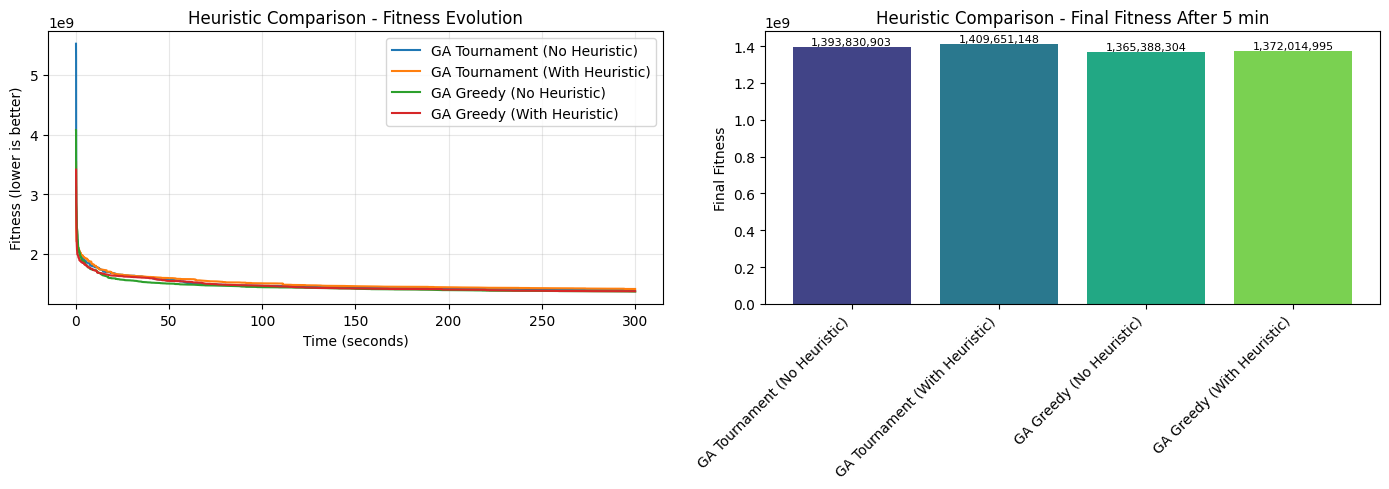

Saved: docs/02_heuristic_comparison/convergence_rate.png


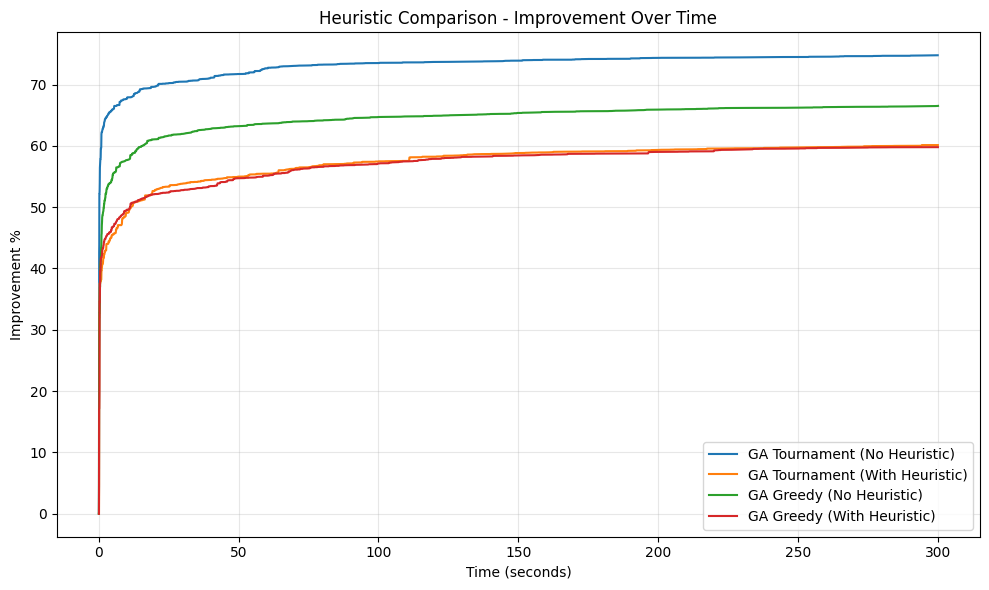

Saved: docs/02_heuristic_comparison/phenotypes_grid.png


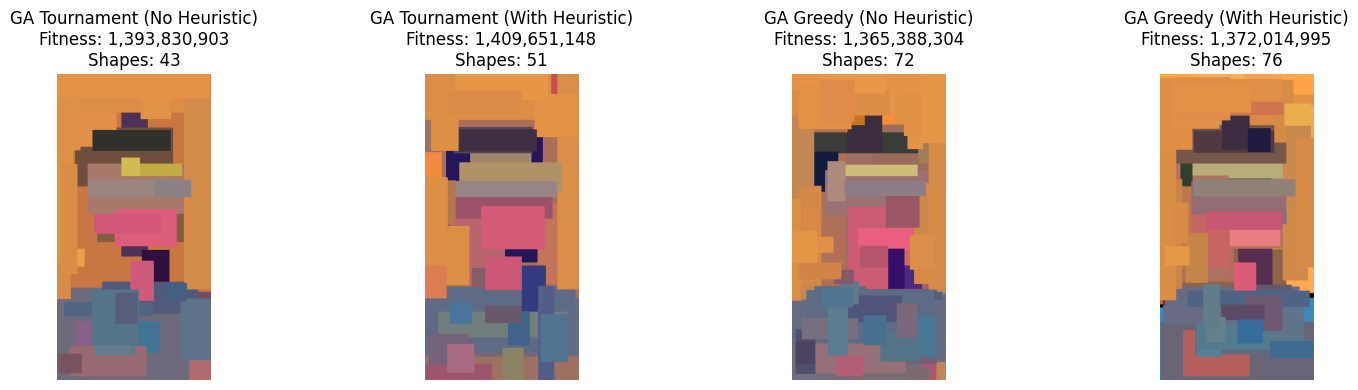

In [7]:
plot_fitness_by_time(results_heuristic, "Heuristic Comparison", save_dir=EXP2_DIR)
plot_convergence_rate(results_heuristic, "Heuristic Comparison", save_dir=EXP2_DIR)
show_phenotypes(results_heuristic, save_dir=EXP2_DIR)

---
## 3. Fitness Metrics: L1 vs L2

In [8]:
EXP3_DIR = ensure_dir(DOCS_DIR / "03_fitness_metrics")

results_fitness = []

# Hill Climbing with L2
start_geno = initialize_grid(original_img, w, h, Rect, grid_size=GRID_SIZE)
results_fitness.append(run_experiment(
    "HC - L2 (SSD)",
    hill_climbing,
    geno=start_geno, original_img=original_img, shape_class=Rect,
    max_it=MAX_ITER, max_time=MAX_TIME_SEC,
    fitness_fn=compute_fitness, track_by_time=True
))

# Hill Climbing with L1
start_geno = initialize_grid(original_img, w, h, Rect, grid_size=GRID_SIZE)
results_fitness.append(run_experiment(
    "HC - L1 (Manhattan)",
    hill_climbing,
    geno=start_geno, original_img=original_img, shape_class=Rect,
    max_it=MAX_ITER, max_time=MAX_TIME_SEC,
    fitness_fn=compute_fitness_l1, track_by_time=True
))

# GA Tournament with L2
results_fitness.append(run_experiment(
    "GA Tournament - L2 (SSD)",
    ga_tournament,
    original_img=original_img, shape_class=Rect,
    pop_size=POP_SIZE, max_it=MAX_ITER, max_time=MAX_TIME_SEC,
    fitness_fn=compute_fitness, track_by_time=True
))

# GA Tournament with L1
results_fitness.append(run_experiment(
    "GA Tournament - L1 (Manhattan)",
    ga_tournament,
    original_img=original_img, shape_class=Rect,
    pop_size=POP_SIZE, max_it=MAX_ITER, max_time=MAX_TIME_SEC,
    fitness_fn=compute_fitness_l1, track_by_time=True
))


Running: HC - L2 (SSD)


Hill Climbing:   3%|▎         | 28405/1000000 [05:00<2:51:01, 94.68it/s, Score=1,310,606,311, Stag=64] 


Stopping at iteration 28405 - time limit reached (300.0s)
Final fitness: 1,310,606,311
Shapes: 94
Time: 300.01s (5.00 min)
Iterations completed: 28405

Running: HC - L1 (Manhattan)


Hill Climbing:   3%|▎         | 32375/1000000 [05:00<2:29:26, 107.92it/s, Score=14,905,297, Stag=59] 


Stopping at iteration 32375 - time limit reached (300.0s)
Final fitness: 14,905,297
Shapes: 77
Time: 300.01s (5.00 min)
Iterations completed: 32375

Running: GA Tournament - L2 (SSD)
Initializing Population...


GA (tournament):   0%|          | 2681/1000000 [05:00<31:00:40,  8.93it/s, Best=1,362,545,324, Shapes=41]


Stopping at generation 2681 - time limit reached (300.0s)
Final fitness: 1,362,545,324
Shapes: 41
Time: 300.11s (5.00 min)
Iterations completed: 2681

Running: GA Tournament - L1 (Manhattan)
Initializing Population...


GA (tournament):   0%|          | 2932/1000000 [05:00<28:20:52,  9.77it/s, Best=15,972,816, Shapes=34]

Stopping at generation 2932 - time limit reached (300.0s)
Final fitness: 15,972,816
Shapes: 34
Time: 300.10s (5.00 min)
Iterations completed: 2932


Saved: docs/03_fitness_metrics/fitness_comparison.png


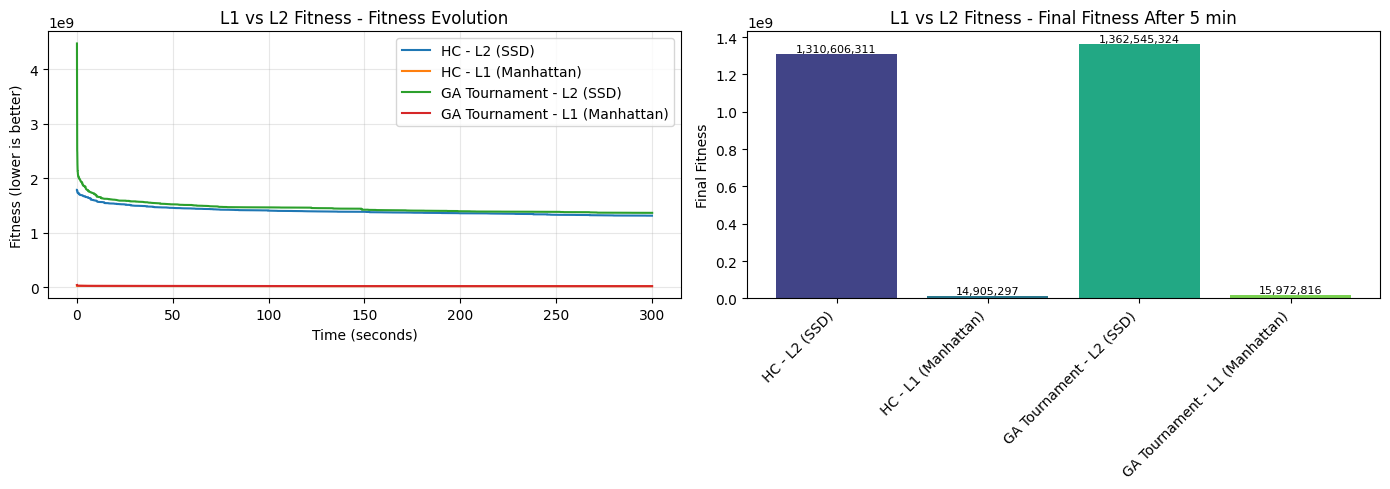

Saved: docs/03_fitness_metrics/phenotypes_grid.png


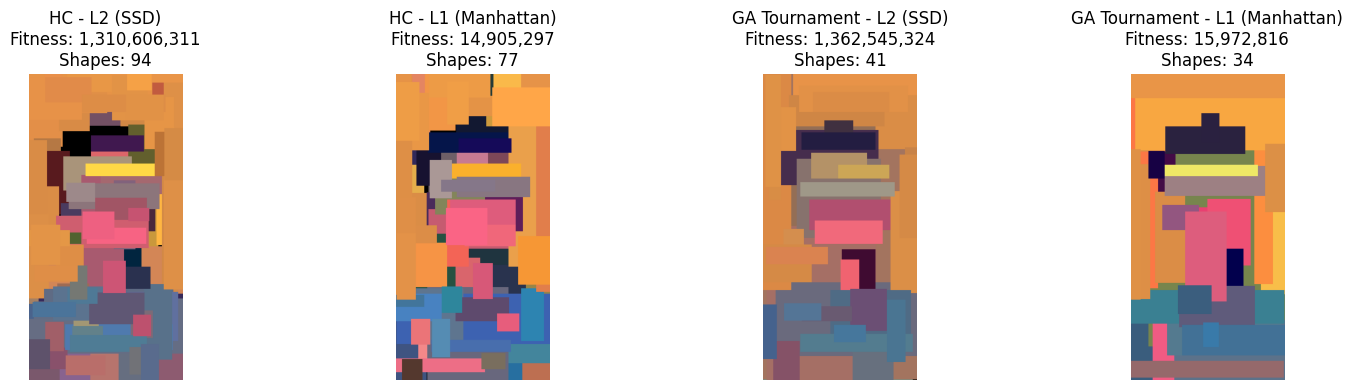

In [9]:
plot_fitness_by_time(results_fitness, "L1 vs L2 Fitness", save_dir=EXP3_DIR)
show_phenotypes(results_fitness, save_dir=EXP3_DIR)

---
## 4. Different Shapes: Rect vs Circle vs Ellipse vs Triangle

In [10]:
EXP4_DIR = ensure_dir(DOCS_DIR / "04_shape_comparison")

results_shapes = []

for shape_name, shape_class in [("Rect", Rect), ("Circle", Circle), ("Ellipse", Ellipse), ("Triangle", Triangle)]:
    # Hill Climbing
    start_geno = initialize_grid(original_img, w, h, shape_class, grid_size=GRID_SIZE)
    results_shapes.append(run_experiment(
        f"HC - {shape_name}",
        hill_climbing,
        geno=start_geno, original_img=original_img, shape_class=shape_class,
        max_it=MAX_ITER, max_time=MAX_TIME_SEC,
        fitness_fn=compute_fitness, track_by_time=True
    ))
    
    # GA Tournament
    results_shapes.append(run_experiment(
        f"GA - {shape_name}",
        ga_tournament,
        original_img=original_img, shape_class=shape_class,
        pop_size=POP_SIZE, max_it=MAX_ITER, max_time=MAX_TIME_SEC,
        fitness_fn=compute_fitness, track_by_time=True
    ))


Running: HC - Rect


Hill Climbing:   3%|▎         | 28852/1000000 [05:00<2:48:17, 96.17it/s, Score=1,288,553,853, Stag=64] 


Stopping at iteration 28852 - time limit reached (300.0s)
Final fitness: 1,288,553,853
Shapes: 92
Time: 300.01s (5.00 min)
Iterations completed: 28852

Running: GA - Rect
Initializing Population...


GA (tournament):   0%|          | 2735/1000000 [05:00<30:23:43,  9.11it/s, Best=1,390,785,173, Shapes=41]


Stopping at generation 2735 - time limit reached (300.0s)
Final fitness: 1,390,785,173
Shapes: 41
Time: 300.10s (5.00 min)
Iterations completed: 2735

Running: HC - Circle


Hill Climbing:   1%|          | 11748/1000000 [05:00<7:00:36, 39.16it/s, Score=1,282,411,478, Stag=5] 


Stopping at iteration 11748 - time limit reached (300.0s)
Final fitness: 1,282,411,478
Shapes: 278
Time: 300.01s (5.00 min)
Iterations completed: 11748

Running: GA - Circle
Initializing Population...


GA (tournament):   0%|          | 2178/1000000 [05:00<38:11:43,  7.26it/s, Best=1,306,600,710, Shapes=86]


Stopping at generation 2178 - time limit reached (300.0s)
Final fitness: 1,306,600,710
Shapes: 86
Time: 300.14s (5.00 min)
Iterations completed: 2178

Running: HC - Ellipse


Hill Climbing:   2%|▏         | 16374/1000000 [05:00<5:00:22, 54.58it/s, Score=1,304,357,202, Stag=7] 


Stopping at iteration 16374 - time limit reached (300.0s)
Final fitness: 1,304,357,202
Shapes: 152
Time: 300.02s (5.00 min)
Iterations completed: 16374

Running: GA - Ellipse
Initializing Population...


GA (tournament):   0%|          | 2607/1000000 [04:59<31:52:54,  8.69it/s, Best=1,349,751,590, Shapes=53]


Stopping at generation 2607 - time limit reached (300.0s)
Final fitness: 1,349,751,590
Shapes: 53
Time: 300.00s (5.00 min)
Iterations completed: 2607

Running: HC - Triangle


Hill Climbing:   2%|▏         | 23075/1000000 [05:00<3:31:41, 76.91it/s, Score=2,269,221,255, Stag=330]


Stopping at iteration 23075 - time limit reached (300.0s)
Final fitness: 2,269,221,255
Shapes: 132
Time: 300.02s (5.00 min)
Iterations completed: 23075

Running: GA - Triangle
Initializing Population...


GA (tournament):   0%|          | 2665/1000000 [05:00<31:11:22,  8.88it/s, Best=2,571,440,004, Shapes=63]

Stopping at generation 2665 - time limit reached (300.0s)
Final fitness: 2,571,440,004
Shapes: 63
Time: 300.03s (5.00 min)
Iterations completed: 2665


Saved: docs/04_shape_comparison/fitness_comparison.png


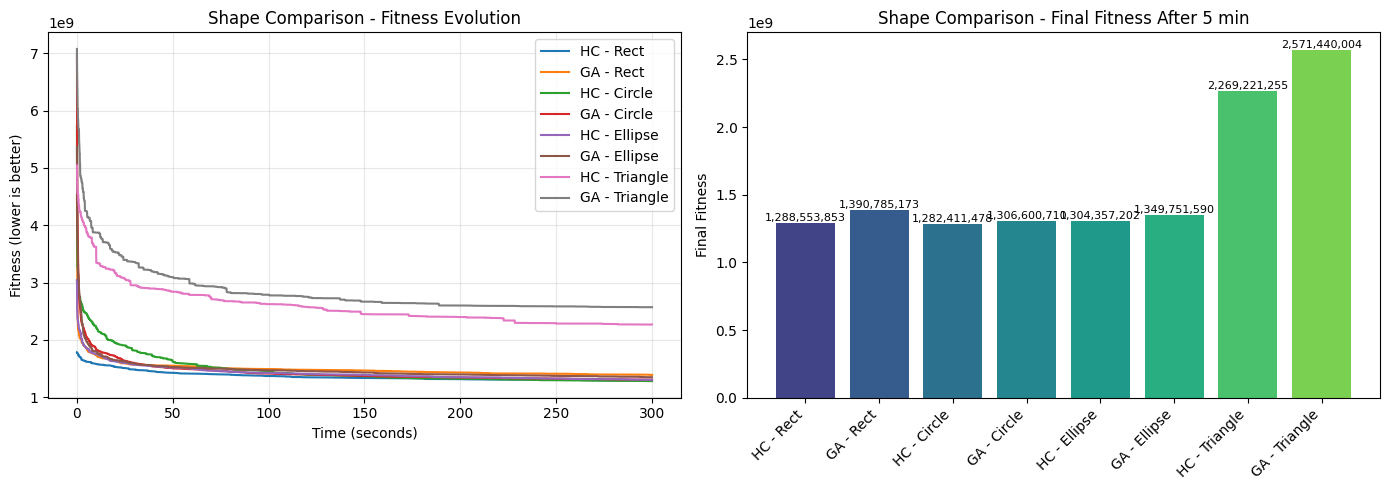

Saved: docs/04_shape_comparison/phenotypes_grid.png


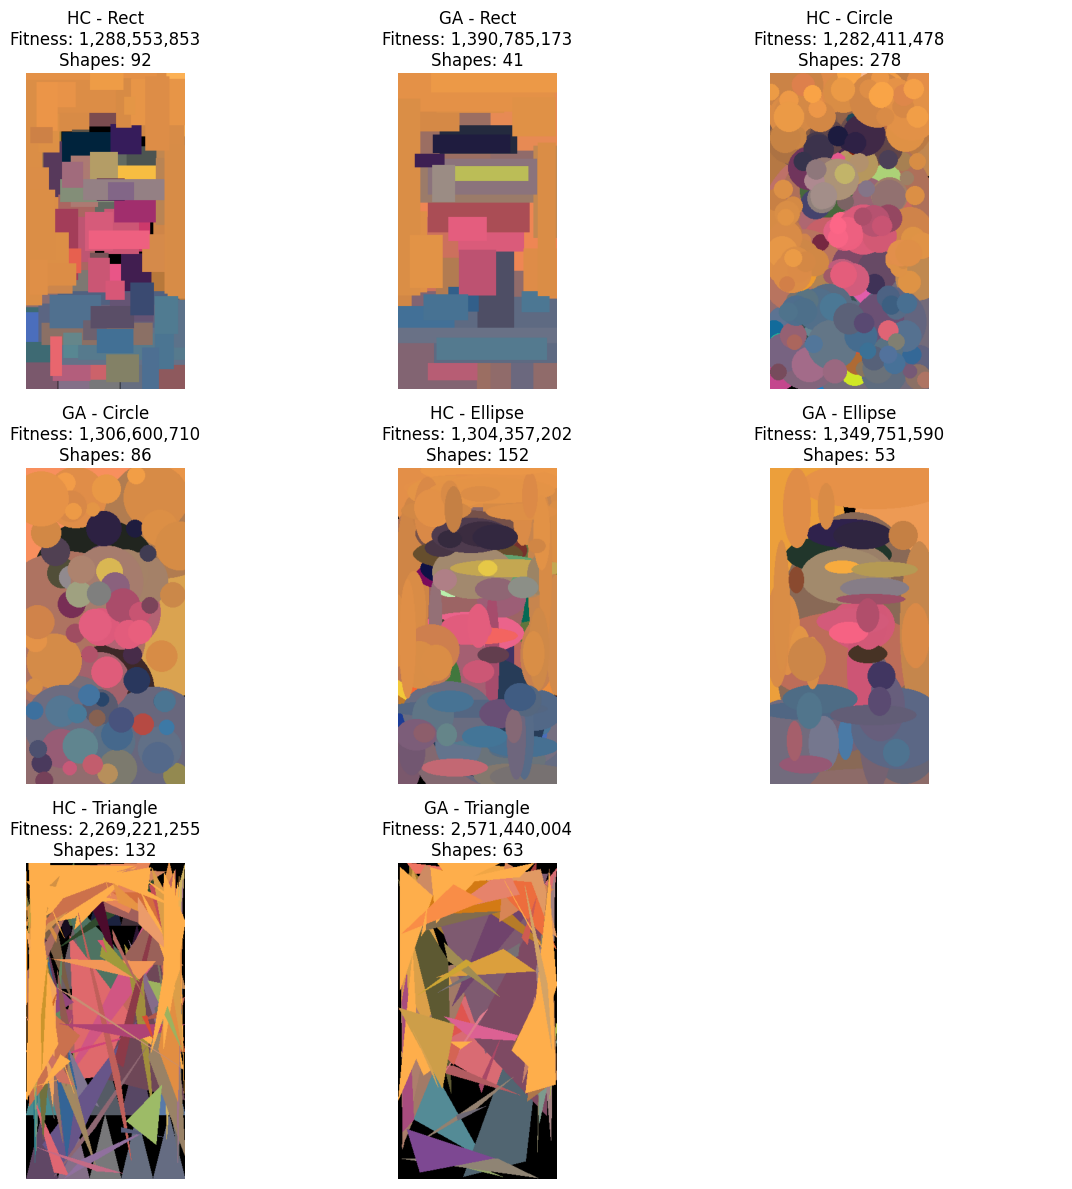

In [11]:
plot_fitness_by_time(results_shapes, "Shape Comparison", save_dir=EXP4_DIR)
show_phenotypes(results_shapes, cols=3, save_dir=EXP4_DIR)

---
## 5. Summary Table

In [12]:
import pandas as pd

SUMMARY_DIR = ensure_dir(DOCS_DIR / "05_summary")

# Combine all results
all_results = results_basic + results_heuristic + results_fitness + results_shapes

# Create summary dataframe
summary_df = pd.DataFrame([
    {
        'Experiment': r['name'],
        'Final Fitness': r['final_fitness'],
        'Shapes': r['shapes'],
        'Iterations': r['iterations'],
        'Time (min)': r['time']/60
    }
    for r in all_results
])

# Sort by final fitness
summary_df = summary_df.sort_values('Final Fitness').reset_index(drop=True)

# Save to CSV
summary_df.to_csv(SUMMARY_DIR / "results_summary.csv", index=False)
print(f"Saved: {SUMMARY_DIR / 'results_summary.csv'}")

print("\n" + "="*70)
print(f"SUMMARY - ALL EXPERIMENTS ({MAX_TIME_MINUTES} min each)")
print("="*70)
display(summary_df)

Saved: docs/05_summary/results_summary.csv

SUMMARY - ALL EXPERIMENTS (5 min each)


,Experiment,Final Fitness,Shapes,Iterations,Time (min)
0,HC - L1 (Manhattan),14905297,77,32375,5.000151
1,GA Tournament - L1 (Manhattan),15972816,34,2932,5.001658
2,Hill Climbing,1267678366,98,28379,5.000201
3,Simulated Annealing,1274659258,85,31450,5.000243
4,HC - Circle,1282411478,278,11748,5.000172
5,HC - Rect,1288553853,92,28852,5.000129
6,HC - Ellipse,1304357202,152,16374,5.000253
7,GA - Circle,1306600710,86,2178,5.002283
8,HC - L2 (SSD),1310606311,94,28405,5.000163
9,GA - Ellipse,1349751590,53,2607,5.000017


---
## 6. Best Result Visualization

🏆 Best Result: HC - L1 (Manhattan)
   Fitness: 14,905,297
   Shapes: 77
   Iterations: 32375
Saved: docs/05_summary/best_result_comparison.png


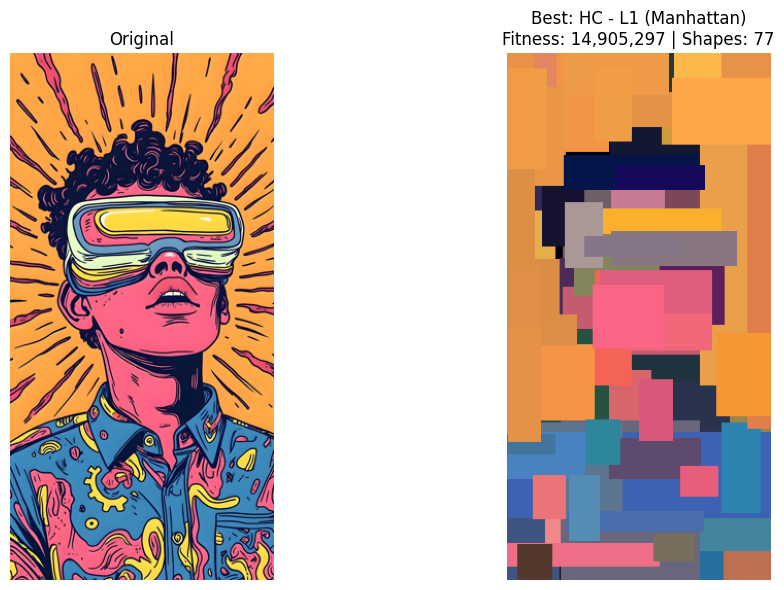

Saved: docs/05_summary/best_phenotype.png


In [13]:
# Find best result
best_result = min(all_results, key=lambda r: r['final_fitness'])

print(f"🏆 Best Result: {best_result['name']}")
print(f"   Fitness: {best_result['final_fitness']:,.0f}")
print(f"   Shapes: {best_result['shapes']}")
print(f"   Iterations: {best_result['iterations']}")

# Display side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(original_img)
axes[0].set_title("Original")
axes[0].axis("off")

best_phenotype = generate_phenotype(best_result['geno'].w, best_result['geno'].h, best_result['geno'].shapes)
axes[1].imshow(best_phenotype)
axes[1].set_title(f"Best: {best_result['name']}\nFitness: {best_result['final_fitness']:,.0f} | Shapes: {best_result['shapes']}")
axes[1].axis("off")

plt.tight_layout()
plt.savefig(SUMMARY_DIR / "best_result_comparison.png", dpi=150, bbox_inches='tight')
print(f"Saved: {SUMMARY_DIR / 'best_result_comparison.png'}")
plt.show()

# Save best phenotype separately
Image.fromarray(best_phenotype).save(SUMMARY_DIR / "best_phenotype.png")
print(f"Saved: {SUMMARY_DIR / 'best_phenotype.png'}")

---
## 7. Fitness Improvement Analysis

In [14]:
# Analyze improvement rate for basic algorithms
print("\nImprovement Analysis (Basic Algorithms):")
print("-" * 70)
print(f"{'Algorithm':<25} | {'Start Fitness':>15} | {'End Fitness':>15} | {'Improvement':>10}")
print("-" * 70)

improvement_data = []
for r in results_basic:
    if not r['history']:
        continue
    
    start_fit = r['history'][0][1]
    end_fit = r['history'][-1][1]
    improvement = (start_fit - end_fit) / start_fit * 100
    
    print(f"{r['name']:<25} | {start_fit:>15,.0f} | {end_fit:>15,.0f} | {improvement:>9.2f}%")
    improvement_data.append({'Algorithm': r['name'], 'Start': start_fit, 'End': end_fit, 'Improvement %': improvement})

# Save improvement analysis
pd.DataFrame(improvement_data).to_csv(SUMMARY_DIR / "improvement_analysis.csv", index=False)
print(f"\nSaved: {SUMMARY_DIR / 'improvement_analysis.csv'}")


Improvement Analysis (Basic Algorithms):
----------------------------------------------------------------------
Algorithm                 |   Start Fitness |     End Fitness | Improvement
----------------------------------------------------------------------
Hill Climbing             |   1,785,455,298 |   1,267,678,366 |     29.00%
Simulated Annealing       |   1,769,954,306 |   1,274,659,258 |     27.98%
GA Greedy                 |   4,985,427,048 |   1,353,826,460 |     72.84%
GA Tournament             |   5,119,364,908 |   1,375,076,614 |     73.14%

Saved: docs/05_summary/improvement_analysis.csv


In [15]:
print("\n" + "="*50)
print("ALL OUTPUT FILES SAVED TO:")
print("="*50)
for exp_dir in sorted(DOCS_DIR.iterdir()):
    if exp_dir.is_dir():
        print(f"\n📁 {exp_dir.name}/")
        for f in sorted(exp_dir.iterdir()):
            print(f"   └── {f.name}")
    else:
        print(f"📄 {exp_dir.name}")


ALL OUTPUT FILES SAVED TO:

📁 01_all_algorithms/
   └── convergence_rate.png
   └── fitness_comparison.png
   └── phenotype_ga_greedy.png
   └── phenotype_ga_tournament.png
   └── phenotype_hill_climbing.png
   └── phenotype_simulated_annealing.png
   └── phenotypes_grid.png

📁 02_heuristic_comparison/
   └── convergence_rate.png
   └── fitness_comparison.png
   └── phenotype_ga_greedy_no_heuristic.png
   └── phenotype_ga_greedy_with_heuristic.png
   └── phenotype_ga_tournament_no_heuristic.png
   └── phenotype_ga_tournament_with_heuristic.png
   └── phenotypes_grid.png

📁 03_fitness_metrics/
   └── fitness_comparison.png
   └── phenotype_ga_tournament_-_l1_manhattan.png
   └── phenotype_ga_tournament_-_l2_ssd.png
   └── phenotype_hc_-_l1_manhattan.png
   └── phenotype_hc_-_l2_ssd.png
   └── phenotypes_grid.png

📁 04_shape_comparison/
   └── fitness_comparison.png
   └── phenotype_ga_-_circle.png
   └── phenotype_ga_-_ellipse.png
   └── phenotype_ga_-_rect.png
   └── phenotype_ga_-_tr